### Summary

In this notebook we are going to attempt the facial keypoint detection Kaggle Competition, found here: https://www.kaggle.com/competitions/facial-keypoints-detection/overview. The Problem involves determinging the location in images of 15 different features. We will be identifying things like edges of mouth, nose, eye, etc, on images of human faces. We will do this by utilizing Convolutional Neural Networks that will extract features and deduce their locations. The code for this jupyter notebook can be found at: https://github.com/Jakagie/ml3-facial-features.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from keras import layers, optimizers
from keras.layers import Input, LeakyReLU, Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D
from keras.models import Sequential

import os
import cv2
from sklearn.model_selection import train_test_split
import shutil

#this is here since my gpu was not large enough and led to crashes
tf.config.set_visible_devices([], 'GPU')

2025-04-28 21:46:28.168867: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745898388.244768   87649 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745898388.267166   87649 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-28 21:46:28.435337: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Data

We are given three data files.

training.csv includes 7049 training images, each including (x,y) coordinates for 15 keypoints. X and y for each keypoint are stored as separate columns.

test.csv includes 1783 test images.

Idlookuptable defines which keypoints are in which image and will be used for submission at the end.

submissionFileFormat.csv includes a list of 27124 keypoints to predict. Each row contains a RowId, ImageId, FeatureName, Location. FeatureName are "left_eye_center_x," "right_eyebrow_outer_end_y," etc. Location is what we will need to predict.

Let's get this into our notebook.

In [2]:
train_data = pd.read_csv("facial-keypoints-detection/training.csv")
test_data = pd.read_csv("facial-keypoints-detection/test.csv")
idlookuptable = pd.read_csv("facial-keypoints-detection/IdLookupTable.csv")

Head() was transposed to make it significantly easier to read due to the large number of columns.

In [3]:
train_data.head().T

,0,1,2,3,4
left_eye_center_x,66.033564,64.332936,65.057053,65.225739,66.725301
left_eye_center_y,39.002274,34.970077,34.909642,37.261774,39.621261
right_eye_center_x,30.227008,29.949277,30.903789,32.023096,32.24481
right_eye_center_y,36.421678,33.448715,34.909642,37.261774,38.042032
left_eye_inner_corner_x,59.582075,58.85617,59.412,60.003339,58.56589
left_eye_inner_corner_y,39.647423,35.274349,36.320968,39.127179,39.621261
left_eye_outer_corner_x,73.130346,70.722723,70.984421,72.314713,72.515926
left_eye_outer_corner_y,39.969997,36.187166,36.320968,38.380967,39.884466
right_eye_inner_corner_x,36.356571,36.034723,37.678105,37.618643,36.98238
right_eye_inner_corner_y,37.389402,34.361532,36.320968,38.754115,39.094852


In [4]:
test_data.head().T

,0,1,2,3,4
ImageId,1,2,3,4,5
Image,182 183 182 182 180 180 176 169 156 137 124 10...,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...,177 176 174 170 169 169 168 166 166 166 161 14...,176 174 174 175 174 174 176 176 175 171 165 15...,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


We can see that the training data has columns for every specific feature split into x and y. They also include an image column. The test data has an id and then just the image.

In [5]:
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

In [6]:
train_data.isnull().any().value_counts()

True     28
False     3
Name: count, dtype: int64

We can see that there are a large number of null values. However, we can see that every paired x and y has the same number of non_null values. Similarly, some features have substantially more null values than others. Notably, Image and nose tip (x,y) have no null values.

We are going to handle the nulls by replacing them with their mean value. This is not perfect but will allow us to ignore them going forward. Other ways to handle this would be to replace them with the most recent or next example of them. This would likely have similar performance but the dataset is large enough I am not going to test this. A third way would be interpolation, but this would likely be meaningless or hamrful.

We are going to need to handle images as well. We will normalize their pixels so that they are all between 0 and 1 rather than 0 and 255.

In [7]:
for i in range(30):
    train_data.iloc[:,i].fillna(int(train_data.iloc[:,i].mean()), inplace = True)

/tmp/ipykernel_87649/1603368638.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data.iloc[:,i].fillna(int(train_data.iloc[:,i].mean()), inplace = True)


In [8]:
train_data.isnull().any().value_counts()

False    31
Name: count, dtype: int64

In [9]:
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7049 non-null   float64
 1   left_eye_center_y          7049 non-null   float64
 2   right_eye_center_x         7049 non-null   float64
 3   right_eye_center_y         7049 non-null   float64
 4   left_eye_inner_corner_x    7049 non-null   float64
 5   left_eye_inner_corner_y    7049 non-null   float64
 6   left_eye_outer_corner_x    7049 non-null   float64
 7   left_eye_outer_corner_y    7049 non-null   float64
 8   right_eye_inner_corner_x   7049 non-null   float64
 9   right_eye_inner_corner_y   7049 non-null   float64
 10  right_eye_outer_corner_x   7049 non-null   float64
 11  right_eye_outer_corner_y   7049 non-null   float64
 12  left_eyebrow_inner_end_x   7049 non-null   float64
 13  left_eyebrow_inner_end_y   7049 non-null   float

Note that we are only going to be using one thousand of the seven thousand images due to hardware constraints.

In [10]:
images = []
y_train = []
#for i in range(len(train_data)):
#    img = train_data["Image"][i].split()
#    images.append(img)
image_num = 1000

for i in range(image_num):
    img = train_data["Image"][i].split()
    images.append(img)

images = np.array(images, dtype = "float")
x_train = images.reshape(-1,96,96,1)
train_data = train_data.drop("Image", axis = 1)

for i in range(image_num):
    y = train_data.iloc[i,:]
    y_train.append(y)

y_train = np.array(y_train, dtype = "float")

Here are two of the images

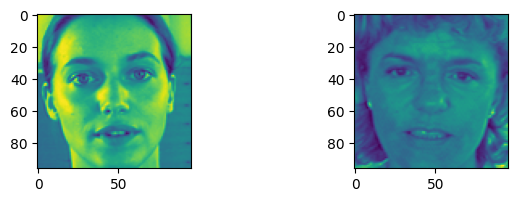

In [63]:
plt.figure(figsize = (15,2))
plt.subplot(1,1,1)
imgplot = plt.imshow(x_train[42].reshape(96,96))
plt.subplot(1,2,1)
imgplot = plt.imshow(x_train[137].reshape(96,96))

Considering their colorations, let's look at the values at each pixel.

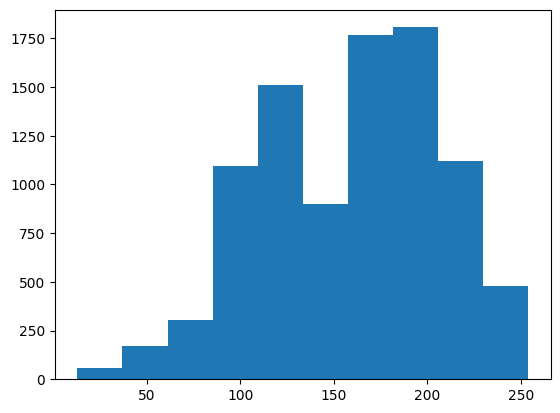

In [12]:
plt.hist(x_train[137].flatten())
plt.show()

In [13]:
print(np.max(x_train[137].reshape(96,96)))
print(np.min(x_train[137].reshape(96,96)))

254.0
13.0


It appears that the value at each pixel is between 0 and 255. Neural Networks typically work best on numbers between 0 and 1 so we will scale them down.

In [14]:
x_train = x_train /255

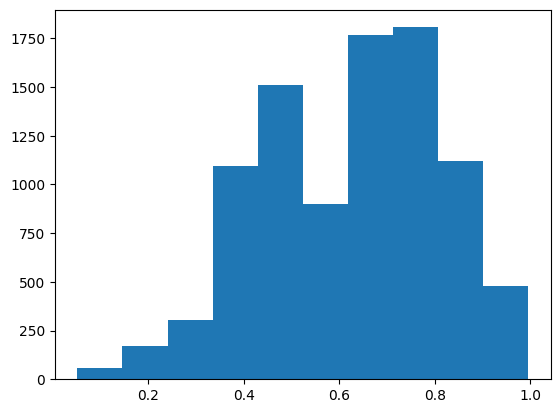

In [15]:
plt.hist(x_train[137].flatten())
plt.show()

In [16]:
print(np.max(x_train[137].reshape(96,96)))
print(np.min(x_train[137].reshape(96,96)))

0.996078431372549
0.050980392156862744


### Architecture

For this project we are going to try various iterations of convolutional neural networks. These types of models are particularly good at image processing since they allow for cascading feature extraction. We will start with very simple models and add layers and complexity as we go until we find a model that produces a good enough result for this competition. 

We will start with a model of 2 conv2d followed by a maxpool, twice. The model will end by flattening and then using a Dense(30) layer to extract the locations of the 30 features. This should give us a large amount of feature extraction without having too large an amount of layers at the start. This startiing model was chosen as it resembles our discussions from class, with the addition at the end for feature extraction output.

Then we will add LeakyReLU layers.

Then we will add Batch Normalization Layers.

Finally, we will add sets of 2 convd, leakyrelu, batch normalization, and maxpool layers until desired performance is achieved. This final model we will then train with all data in order to attempt to get the best score possible on the leaderboard.

In [19]:
naive_model = Sequential()

naive_model.add(Input(shape=(96, 96, 1))),
naive_model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
naive_model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
naive_model.add(MaxPool2D(pool_size=(2, 2)))
naive_model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
naive_model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
naive_model.add(MaxPool2D(pool_size=(2, 2)))
naive_model.add(Flatten())
naive_model.add(Dense(64, activation = "relu"))
naive_model.add(Dense(30))

naive_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 96, 96, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 96, 96, 32)     │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 48, 48, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 48, 48, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     2,359,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 30)             │         1,950 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,426,110 (9.25 MB)

 Trainable params: 2,426,110 (9.25 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
naive_model.compile(optimizer='adam', 
              loss='mean_squared_error',
              metrics=['mae'])

In [21]:
naive_model_history = naive_model.fit(x_train,y_train,epochs = 5,batch_size = 256,validation_split = 0.2)

Epoch 1/5


I0000 00:00:1745891308.549717   78092 service.cc:148] XLA service 0x71612000be70 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745891308.549896   78092 service.cc:156]   StreamExecutor device (0): Host, Default Version
2025-04-28 19:48:28.598261: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745891309.039551   78092 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-04-28 19:48:29.040787: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2312347432 exceeds 10% of free system memory.


1/4 ━━━━━━━━━━━━━━━━━━━━ 38s 13s/step - loss: 2578.2429 - mae: 47.3356

2025-04-28 19:48:40.698146: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2312347432 exceeds 10% of free system memory.


2/4 ━━━━━━━━━━━━━━━━━━━━ 23s 12s/step - loss: 2539.9023 - mae: 46.8975

2025-04-28 19:48:52.396697: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2312347432 exceeds 10% of free system memory.


4/4 ━━━━━━━━━━━━━━━━━━━━ 39s 9s/step - loss: 2403.0269 - mae: 45.1915 - val_loss: 1516.1997 - val_mae: 31.3210
Epoch 2/5


2025-04-28 19:49:06.977742: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2312347432 exceeds 10% of free system memory.


1/4 ━━━━━━━━━━━━━━━━━━━━ 34s 12s/step - loss: 1561.7700 - mae: 31.6129

2025-04-28 19:49:18.563701: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2312347432 exceeds 10% of free system memory.


4/4 ━━━━━━━━━━━━━━━━━━━━ 38s 9s/step - loss: 1240.9264 - mae: 28.3216 - val_loss: 740.3467 - val_mae: 22.6879
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 39s 9s/step - loss: 669.5003 - mae: 21.3143 - val_loss: 470.9333 - val_mae: 17.4186
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 9s/step - loss: 446.4644 - mae: 16.8987 - val_loss: 343.5188 - val_mae: 14.7014
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 39s 9s/step - loss: 324.2385 - mae: 14.1688 - val_loss: 271.1957 - val_mae: 12.9313


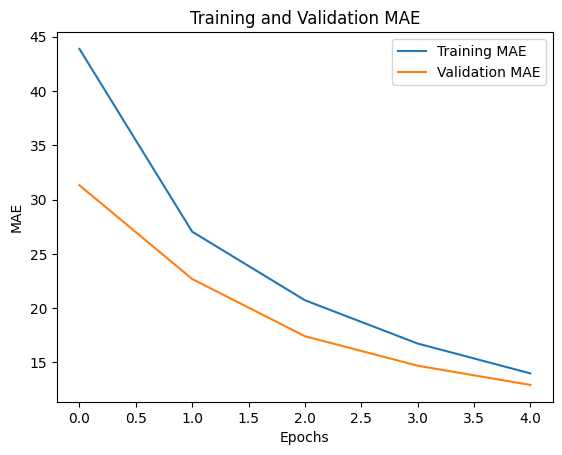

In [22]:
plt.plot(naive_model_history.history['mae'], label='Training MAE')
plt.plot(naive_model_history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend()
plt.show()

Looking at the above, it seems like 5 epochs was not enough as the MAE has not plateaued. For the next model, we will increase epochs to 6. I am still keeping the epochs low to reduce training time. 

Now, we will alter the model to explicitly have leaky relu after every convolutional layer to observe if there is any performance difference..

In [23]:
relu_model = Sequential()

relu_model.add(Input(shape=(96, 96, 1))),
relu_model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
relu_model.add(LeakyReLU())
relu_model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
relu_model.add(LeakyReLU())
relu_model.add(MaxPool2D(pool_size=(2, 2)))
relu_model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
relu_model.add(LeakyReLU())
relu_model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
relu_model.add(LeakyReLU())
relu_model.add(MaxPool2D(pool_size=(2, 2)))
relu_model.add(Flatten())
relu_model.add(Dense(64, activation = "relu"))
relu_model.add(Dense(30))

relu_model.compile(optimizer='adam', 
                   loss='mean_squared_error',
                   metrics=['mae'])

relu_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 96, 96, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 96, 96, 32)     │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 48, 48, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 48, 48, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │     2,359,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 30)             │         1,950 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,426,110 (9.25 MB)

 Trainable params: 2,426,110 (9.25 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
relu_model_history = relu_model.fit(x_train,y_train,epochs = 6,batch_size = 256,validation_split = 0.2)

Epoch 1/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 47s 10s/step - loss: 2538.0300 - mae: 46.9404 - val_loss: 1856.8634 - val_mae: 39.2028
Epoch 2/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 46s 10s/step - loss: 1595.0654 - mae: 34.9286 - val_loss: 1000.7131 - val_mae: 25.1124
Epoch 3/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 45s 10s/step - loss: 930.0322 - mae: 24.6117 - val_loss: 825.5056 - val_mae: 24.5015
Epoch 4/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 47s 11s/step - loss: 755.8405 - mae: 23.1423 - val_loss: 614.1980 - val_mae: 19.3266
Epoch 5/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 48s 11s/step - loss: 579.0756 - mae: 18.8486 - val_loss: 451.7521 - val_mae: 17.4585
Epoch 6/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 46s 11s/step - loss: 427.5557 - mae: 16.8790 - val_loss: 351.2686 - val_mae: 14.7234


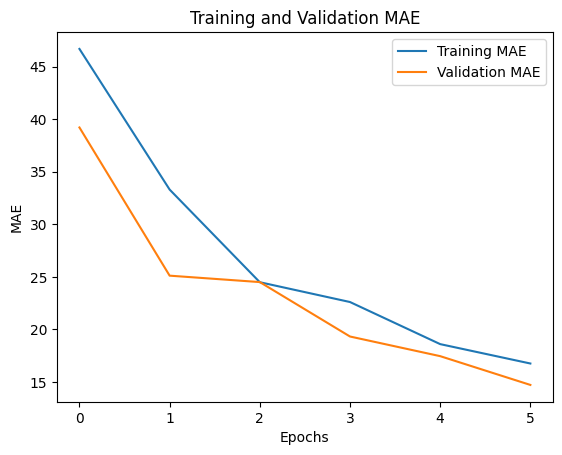

In [25]:
plt.plot(relu_model_history.history['mae'], label='Training MAE')
plt.plot(relu_model_history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend()
plt.show()

It appears that adding the leaky relu slightly decreased performance. However, I would like to see how it compares when a batch normalization layer is added too. Similarly, the increase of epochs to 6 does seem to have increased performance at the tradeoff of training time. I will not increase it any farther at this point but will at the final model. It seems likely that a higher epoch count would lead to a better performance here as the reduction in MAE has not slowed for training or validation data.

At this point, we will try adding batch normalization layers after every leaky relu as well. This has been mentioned to improve performance by stabilizing the model at every step. It recenters and normalizes the values.

In [31]:
normalization_model = Sequential()

normalization_model.add(Input(shape=(96, 96, 1))),
normalization_model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
normalization_model.add(LeakyReLU())
normalization_model.add(BatchNormalization())
normalization_model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
normalization_model.add(LeakyReLU())
normalization_model.add(BatchNormalization())
normalization_model.add(MaxPool2D(pool_size=(2, 2)))
normalization_model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
normalization_model.add(LeakyReLU())
normalization_model.add(BatchNormalization())
normalization_model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
normalization_model.add(LeakyReLU())
normalization_model.add(BatchNormalization())
normalization_model.add(MaxPool2D(pool_size=(2, 2)))
normalization_model.add(Flatten())
normalization_model.add(Dense(64, activation = "relu"))
normalization_model.add(Dense(30))

normalization_model.compile(optimizer='adam', 
                   loss='mean_squared_error',
                   metrics=['mae'])

normalization_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 96, 96, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 96, 96, 32)     │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 48, 48, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 48, 48, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │     2,359,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 30)             │         1,950 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,426,878 (9.26 MB)

 Trainable params: 2,426,494 (9.26 MB)

 Non-trainable params: 384 (1.50 KB)

In [29]:
normalization_model_history = normalization_model.fit(x_train,y_train,epochs = 6,batch_size = 256,validation_split = 0.2)

Epoch 1/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 48s 11s/step - loss: 2017.0116 - mae: 40.5567 - val_loss: 2598.1816 - val_mae: 47.4679
Epoch 2/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 49s 11s/step - loss: 452.9064 - mae: 16.9374 - val_loss: 2562.0969 - val_mae: 47.1434
Epoch 3/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 45s 10s/step - loss: 255.1036 - mae: 12.3304 - val_loss: 2529.8970 - val_mae: 46.8468
Epoch 4/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 48s 11s/step - loss: 138.4823 - mae: 9.3351 - val_loss: 2488.9019 - val_mae: 46.4682
Epoch 5/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 47s 11s/step - loss: 70.4907 - mae: 6.5740 - val_loss: 2492.0515 - val_mae: 46.5169
Epoch 6/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 50s 11s/step - loss: 37.4172 - mae: 4.8310 - val_loss: 2456.0613 - val_mae: 46.1567


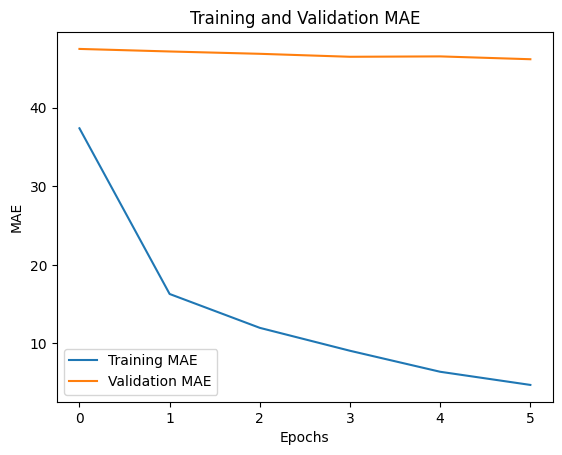

In [30]:
plt.plot(normalization_model_history.history['mae'], label='Training MAE')
plt.plot(normalization_model_history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend()
plt.show()

Unfortunately, it seems like adding in the batch normalization layer dramatically worsens its ability to train. As such, I will not be using them going forward.

The below model adds another cycle of convs, relus, and maxpool. It also removes the previous batch normalization.

In [32]:
three_cycle_model = Sequential()

three_cycle_model.add(Input(shape=(96, 96, 1))),
three_cycle_model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
three_cycle_model.add(LeakyReLU())
three_cycle_model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
three_cycle_model.add(LeakyReLU())
three_cycle_model.add(MaxPool2D(pool_size=(2, 2)))

three_cycle_model.add(Convolution2D(64, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
three_cycle_model.add(LeakyReLU())
three_cycle_model.add(Convolution2D(64, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
three_cycle_model.add(LeakyReLU())
three_cycle_model.add(MaxPool2D(pool_size=(2, 2)))

three_cycle_model.add(Convolution2D(128, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
three_cycle_model.add(LeakyReLU())
three_cycle_model.add(Convolution2D(128, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
three_cycle_model.add(LeakyReLU())
three_cycle_model.add(MaxPool2D(pool_size=(2, 2)))

three_cycle_model.add(Flatten())
three_cycle_model.add(Dense(128, activation = "relu"))
three_cycle_model.add(Dense(30))

three_cycle_model.compile(optimizer='adam', 
                   loss='mean_squared_error',
                   metrics=['mae'])

three_cycle_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 96, 96, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_16 (LeakyReLU)      │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 96, 96, 32)     │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_17 (LeakyReLU)      │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 48, 48, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_18 (LeakyReLU)      │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 48, 48, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_19 (LeakyReLU)      │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 24, 24, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_20 (LeakyReLU)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 24, 24, 128)    │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_21 (LeakyReLU)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 30)             │         3,870 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,649,278 (10.11 MB)

 Trainable params: 2,649,278 (10.11 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
three_cycle_model_history = three_cycle_model.fit(x_train,y_train,epochs = 6,batch_size = 256,validation_split = 0.2)

Epoch 1/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 55s 13s/step - loss: 2512.4216 - mae: 46.7089 - val_loss: 1052.4897 - val_mae: 27.5750
Epoch 2/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 55s 13s/step - loss: 1425.8156 - mae: 30.3038 - val_loss: 1039.5941 - val_mae: 29.1730
Epoch 3/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 53s 12s/step - loss: 1082.7950 - mae: 29.8125 - val_loss: 768.2960 - val_mae: 23.7040
Epoch 4/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 56s 13s/step - loss: 606.1751 - mae: 20.1931 - val_loss: 517.3385 - val_mae: 16.8288
Epoch 5/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 52s 12s/step - loss: 399.6665 - mae: 14.8988 - val_loss: 388.7654 - val_mae: 16.6381
Epoch 6/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 54s 12s/step - loss: 359.5718 - mae: 15.9600 - val_loss: 234.7064 - val_mae: 11.9720


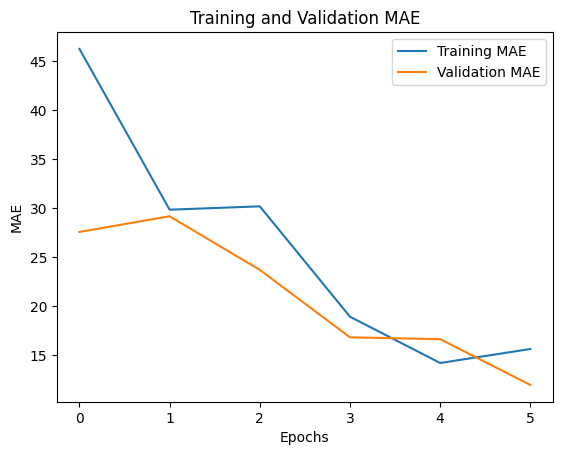

In [34]:
plt.plot(three_cycle_model_history.history['mae'], label='Training MAE')
plt.plot(three_cycle_model_history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend()
plt.show()

This model has ended with the lowest validation MAE so far. Beyond that, it appears that it might still be improving with epochs. As such, now I will attempt to train this model on a larger dataset and for more epochs.  

The below code will create a dataset for training with all of the images, not just the first thousand.

In [18]:
# will reinit the data to get all of them and keep them separate.
full_train_data = pd.read_csv("facial-keypoints-detection/training.csv")

for i in range(30):
    full_train_data.iloc[:,i].fillna(int(full_train_data.iloc[:,i].mean()), inplace = True)
    
full_images = []
full_y_train = []

for i in range(len(full_train_data)):
    img = full_train_data["Image"][i].split()
    full_images.append(img)

full_images = np.array(full_images, dtype = "float")
full_x_train = full_images.reshape(-1,96,96,1)
full_x_train = full_x_train / 255

full_train_data = full_train_data.drop("Image", axis = 1)

for i in range(len(full_train_data)):
    y = full_train_data.iloc[i,:]
    full_y_train.append(y)

full_y_train = np.array(full_y_train, dtype = "float")

print(full_x_train.shape)
print(full_y_train.shape)


/tmp/ipykernel_87649/3704618105.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  full_train_data.iloc[:,i].fillna(int(full_train_data.iloc[:,i].mean()), inplace = True)


(7049, 96, 96, 1)
(7049, 30)


In [20]:
print(full_x_train[0])

[[[0.93333333]
  [0.9254902 ]
  [0.92941176]
  ...
  [0.98039216]
  [0.98039216]
  [0.98039216]]

 [[0.92156863]
  [0.93333333]
  [0.9254902 ]
  ...
  [0.97647059]
  [0.98039216]
  [0.98431373]]

 [[0.92941176]
  [0.9254902 ]
  [0.92941176]
  ...
  [0.98431373]
  [0.98431373]
  [0.98039216]]

 ...

 [[0.72941176]
  [0.71764706]
  [0.70980392]
  ...
  [0.20392157]
  [0.22352941]
  [0.23529412]]

 [[0.74117647]
  [0.7372549 ]
  [0.81176471]
  ...
  [0.23921569]
  [0.27058824]
  [0.30588235]]

 [[0.74901961]
  [0.72156863]
  [0.72156863]
  ...
  [0.2745098 ]
  [0.29411765]
  [0.35294118]]]


In [19]:
print(full_y_train[0])

[66.03356391 39.00227368 30.22700752 36.4216782  59.58207519 39.64742256
 73.13034586 39.96999699 36.35657143 37.3894015  23.45287218 37.3894015
 56.95326316 29.03364812 80.22712782 32.22813835 40.22760902 29.0023218
 16.35637895 29.64747068 44.42057143 57.06680301 61.19530827 79.97016541
 28.61449624 77.38899248 43.3126015  72.93545865 43.13070677 84.48577444]


In [21]:
final_model = Sequential()

final_model.add(Input(shape=(96, 96, 1))),
final_model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
final_model.add(LeakyReLU())
final_model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
final_model.add(LeakyReLU())
final_model.add(MaxPool2D(pool_size=(2, 2)))

final_model.add(Convolution2D(64, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
final_model.add(LeakyReLU())
final_model.add(Convolution2D(64, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
final_model.add(LeakyReLU())
final_model.add(MaxPool2D(pool_size=(2, 2)))

final_model.add(Convolution2D(128, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
final_model.add(LeakyReLU())
final_model.add(Convolution2D(128, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
final_model.add(LeakyReLU())
final_model.add(MaxPool2D(pool_size=(2, 2)))

final_model.add(Flatten())
final_model.add(Dense(128, activation = "relu"))
final_model.add(Dense(30))

final_model.compile(optimizer='adam', 
                   loss='mean_squared_error',
                   metrics=['mae'])

final_model.summary()

/home/jkagie/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 96, 96, 32)     │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 128)    │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         3,870 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,649,278 (10.11 MB)

 Trainable params: 2,649,278 (10.11 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
final_model_history = final_model.fit(full_x_train,full_y_train,epochs = 10,batch_size = 256,validation_split = 0.2)

Epoch 1/10


I0000 00:00:1745898641.378730   87945 service.cc:148] XLA service 0x7eb028003db0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745898641.378978   87945 service.cc:156]   StreamExecutor device (0): Host, Default Version
2025-04-28 21:50:41.430220: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745898641.938406   87945 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-04-28 21:50:41.939781: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2897591672 exceeds 10% of free system memory.


 1/23 ━━━━━━━━━━━━━━━━━━━━ 6:17 17s/step - loss: 2602.3760 - mae: 47.4483

2025-04-28 21:50:57.635672: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2897591672 exceeds 10% of free system memory.


 2/23 ━━━━━━━━━━━━━━━━━━━━ 5:39 16s/step - loss: 2599.1016 - mae: 47.4239

2025-04-28 21:51:13.804817: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2897591672 exceeds 10% of free system memory.


 3/23 ━━━━━━━━━━━━━━━━━━━━ 5:22 16s/step - loss: 2582.3118 - mae: 47.2617

2025-04-28 21:51:29.876837: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2897591672 exceeds 10% of free system memory.


 4/23 ━━━━━━━━━━━━━━━━━━━━ 5:02 16s/step - loss: 2543.7449 - mae: 46.8372

2025-04-28 21:51:45.430080: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2897591672 exceeds 10% of free system memory.


23/23 ━━━━━━━━━━━━━━━━━━━━ 352s 15s/step - loss: 1653.5699 - mae: 34.3839 - val_loss: 239.5763 - val_mae: 11.9241
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 370s 16s/step - loss: 177.1971 - mae: 10.3213 - val_loss: 119.8775 - val_mae: 8.1497
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 381s 16s/step - loss: 129.3922 - mae: 8.5298 - val_loss: 114.4553 - val_mae: 7.8669
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 384s 17s/step - loss: 126.0033 - mae: 8.3829 - val_loss: 146.0697 - val_mae: 9.1389
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 380s 16s/step - loss: 131.8772 - mae: 8.5865 - val_loss: 149.7443 - val_mae: 9.2607
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 386s 17s/step - loss: 131.5874 - mae: 8.6335 - val_loss: 117.8504 - val_mae: 8.1304
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 399s 17s/step - loss: 131.2248 - mae: 8.6045 - val_loss: 151.9033 - val_mae: 9.3735
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 390s 17s/step - loss: 138.3058 - mae: 8.7931 - val_loss: 110.8035 - val_mae: 7.8518
Epoch 9/10
23/23 ━━━━━━━━━━━━━━

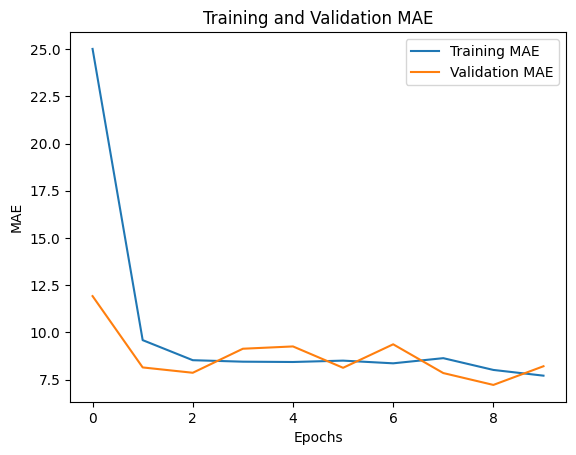

In [24]:
plt.plot(final_model_history.history['mae'], label='Training MAE')
plt.plot(final_model_history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend()
plt.show()

This model did significantly better than the previous ones! However, it appears that the larger number of images led it to converge to the dataset faster. It might be useful to reduce the training rate. Adding back in the normalization layers might also help to derive value from the larger number of epochs. 

### Results

Let's submit this final model with its predictions for a final score. The below code creates the submission file in the format required.

In [25]:
timag = []
for i in range(len(test_data)):
    timg = test_data['Image'][i].split()    
    timag.append(timg)

In [26]:
timage_list = np.array(timag,dtype = 'float')
x_test = timage_list.reshape(-1,96,96,1) 
x_test = x_test / 255

In [49]:
pred = final_model.predict(x_test)

56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step


Some of the prediction values were slightly over 96, the maximum size. As such, I will cap the values to 96 and lower everything over them to 96.

In [50]:
print(pred)
for i in range(len(pred)):
    for j in range(len(pred[i])):
        #print(pred[i][j])
        if pred[i][j] > 96:
            pred[i][j] = 96

[[68.75961  39.56963  31.45176  ... 74.90364  50.096478 83.53807 ]
 [51.148132 29.373907 23.069458 ... 55.460106 37.7643   61.14751 ]
 [59.763737 34.337257 28.329386 ... 66.3222   44.437828 72.915   ]
 ...
 [67.5495   38.901474 30.855211 ... 73.45112  48.992558 80.21207 ]
 [73.19945  42.187138 33.382088 ... 79.78247  53.42605  87.047455]
 [46.982113 27.222208 21.424812 ... 51.243793 34.58693  56.400356]]


In [51]:
lookid_list = list(idlookuptable['FeatureName'])
imageID = list(idlookuptable['ImageId']-1)
pre_list = list(pred)

In [52]:
rowid = idlookuptable['RowId']
rowid=list(rowid)

In [53]:
feature = []
for f in list(idlookuptable['FeatureName']):
    feature.append(lookid_list.index(f))

In [54]:
preded = []
for x,y in zip(imageID,feature):
    preded.append(pre_list[x][y])

In [55]:
rowid = pd.Series(rowid,name = 'RowId')
loc = pd.Series(preded,name = 'Location')

In [56]:
submission = pd.concat([rowid,loc],axis = 1)

In [57]:
submission.to_csv('face_key_detection_submission.csv',index = False)

The score received for this submission is 10.69. This puts us around rank 150 on the leaderboard.

Let's also compare the validation MAE of all of the models. Unfortunately, during one of the trainings the notebook lost all of its variables. As such, I cannot show you them from their history but will instead list them here.

Naive model: 12.9313

Leaky ReLU model: 14.7234

Normalization model: 46.1567

Three cycle model: 11.9720

Final model: 8.2125


From this, we can surmise that adding additional layers and training on more data were large increases. It is likely that if more cycles are added to the model that it will continue to improve. However, training times for this will continue to grow as well. It seemed like adding steps like normalization and leaky relu to small models hurt more than it helped when data and epochs were limited.

Let's try visualizing some of the results.

[68.75961  39.56963  31.45176  39.55009  62.484062 39.45219  76.55801
 38.883068 37.1031   38.88574  23.400772 39.69096  58.25871  30.391151
 82.84186  31.015244 40.69861  30.6149   15.838356 31.68507  50.400604
 63.72985  65.699196 78.78384  33.976704 79.32578  49.694935 74.90364
 50.096478 83.53807 ]


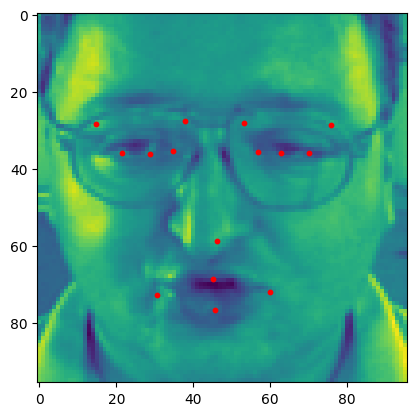

In [62]:
# pred is a list of locations of every feature
# test_x contains the photo
plt.imshow(x_test[42].reshape(96,96))
print(pred[0])

plt.scatter(pred[42][0::2], pred[42][1::2], c="red", s=10)
plt.show()

As you can see, the locations are quite close to their correct locations. The lip locations are primarily in the correct location and the eyes are mostly where they should be.

### Conclusion

Even a basic model was able to make a fairly accurate guess. However, the model consistently became more accurate as more layers were added. It is likely that continuing to add cycles as defined above would continue to improve performance. Similarly, using the whole dataset rather than just approximately a seventh also led to better performance, at the cost of training time.

Lessons Learned: convulutional nueral networks are well-suited for image processing problems. They function efficiently at identifying features, even with quick designs. A single network can be trained to identify a whole host of features. This single moddle was able to fairly accurately identify 15 different features.

Future improvements and ideas:

Adding more and more cycles would be interesting to see the change in performance. Similarly, I would like to see how the models performed at far higher epochs with a lower training rate. I am curious how much better they would be.

Potentially making different models that work concurrently might be superior. As shown in the image above, to a human it seems like the points are grouped into three groups. The mouth area, the right eye, and the left eye. It could be interesting to train a model for each of those and then combine the results for a superior final product. 

Re-adding in normalization in some form would likely improve performance. It was suprising to me just how much adding normalization decreased the efficacy of the model. However, it is possible that adding a large amount of epochs would lead to the combination being an improvement. Unfortunately, with my hardware limitations that was unviable.

### Thank you

This project was interesting to me as an extension of the cancer detection project. I was curious how much more difficult it would be to identify a more diverse set of features rather than one.

Overall, this set of classes was quite valuable and I look forward to utilizing the things I've learned in the future.